## **Set up Environments**

In [ ]:
# !pip install transformers

In [61]:
import torch
from torch import nn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

In [62]:
FAKE_PATH = "/kaggle/input/datasets-fake-new-detection/DataSet_Misinfo_FAKE.csv"
TRUE_PATH = "/kaggle/input/datasets-fake-new-detection/DataSet_Misinfo_TRUE.csv"

df_fake = pd.read_csv(FAKE_PATH)
df_true = pd.read_csv(TRUE_PATH)

In [ ]:
df_fake.head(), df_true.head()

(   Unnamed: 0                                               text
 0           0  Donald Trump just couldn t wish all Americans ...
 1           1  House Intelligence Committee Chairman Devin Nu...
 2           2  On Friday, it was revealed that former Milwauk...
 3           3  On Christmas day, Donald Trump announced that ...
 4           4  Pope Francis used his annual Christmas Day mes...,
    Unnamed: 0                                               text
 0           0  The head of a conservative Republican faction ...
 1           1  Transgender people will be allowed for the fir...
 2           2  The special counsel investigation of links bet...
 3           3  Trump campaign adviser George Papadopoulos tol...
 4           4  President Donald Trump called on the U.S. Post...)

## **1. Data Preprocessing**

#### **1.1 Remove uneccessary columns & Label for the dataset**

Có thể thấy ở 2 cột của bộ dữ liệu đang có cùng 1 cột dư thừa và không sử dụng đến "Unnamed: 0", nên ta sẽ loại bỏ cột này ở cả 2 bộ dữ liệu.
Thứ 2 là bộ dữ liệu mặc dù đã được chia ra fake và real news ở mỗi tệp nhưng chưa được gán nhãn. Vì vậy ta sẽ thực hiện việc gán nhãn cho bộ dữ liệu, với dữ liệu Fake thì sẽ là 0 và Real sẽ là 1

In [64]:
# Remove uneccessary columns in 2 datasets
df_fake.drop("Unnamed: 0", axis = 1, inplace = True)
df_true.drop("Unnamed: 0", axis = 1, inplace = True)

In [65]:
# Label for the dataset
df_fake['label'] = 0
df_true['label'] = 1

# Combine 2 dataset to 1
df = pd.concat([df_fake, df_true])

In [66]:
df.sample(5)

,text,label
31014,WASHINGTON — The White House is considering...,1
31281,‘Ignored’ voter to become ‘absolutely shafted’...,0
24751,"Posted on October 29, 2016 by Baxter Dmitry in...",0
21745,"21st Century Wire says Since the late 1960 s, ...",0
13936,Tow the party line or pay a heavy price. There...,0


In [67]:
print("The shape of the data:", df.shape)

The shape of the data: (78617, 2)


#### **1.2 Check missing and duplicated values**
Kiểm tra giá trị missing

In [68]:
df.isnull().sum().sort_values(ascending=False)

text     29
label     0
dtype: int64

Ở đây đang có 29 dữ liệu missing, chắc chắn là sẽ bỏ đi các giá trị này. Thêm vào đó, có thể sẽ có 1 vài dòng chưa giá trị blank space ' ', mà những giá trị như vậy thì pandas nó không đọc được là giá trị null nên vì vậy sẽ phải chuyển các giá trị blank space ' ' thành giá trị null và loại bỏ đi.

In [69]:
# Function to convert blank space to null value
def blank_to_nan(df):
    tmp = []
    for item in df:
        if item == '':
            tmp.append(np.nan)
        else:
            tmp.append(item)
    return tmp

In [71]:
text = blank_to_nan(df['text'])

In [72]:
tmp = pd.DataFrame({'text': text, 'label': df['label']})

In [73]:
df = tmp.dropna()

In [74]:
print('The shape of data after dropping null values:', df.shape)

The shape of data after dropping null values: (78588, 2)


Kiểm tra giá trị duplicated

In [75]:
df['clean_text'] = df['text'].str.lower().str.strip()

duplicated_texts = df[df.duplicated(subset='clean_text', keep=False)]

/tmp/ipykernel_35/571764310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clean_text'] = df['text'].str.lower().str.strip()


In [76]:
duplicated_texts.head()

,text,label,clean_text
9087,Barbra Streisand was an Obama sycophant and on...,0,barbra streisand was an obama sycophant and on...
9088,Everyone suspected the sketchy Steele Dossier ...,0,everyone suspected the sketchy steele dossier ...
9089,It s been said that good fences make good neig...,0,it s been said that good fences make good neig...
9091,"Friday on MSNBC, climate activist Bill Nye war...",0,"friday on msnbc, climate activist bill nye war..."
9093,"#JokeNewsAfter record, cold temperatures were ...",0,"#jokenewsafter record, cold temperatures were ..."


In [77]:
print("The shape of data:", df.shape)

# Remove duplicated texts
df = df.drop_duplicates(subset = 'clean_text', keep = 'first').drop(columns = 'clean_text')

print("The shape of data after dropping duplicates:", df.shape)

The shape of data: (78588, 3)
The shape of data after dropping duplicates: (68600, 2)


## **2. Explore Data Analysis (EDA)**

#### **2.1 View Label Distribution**

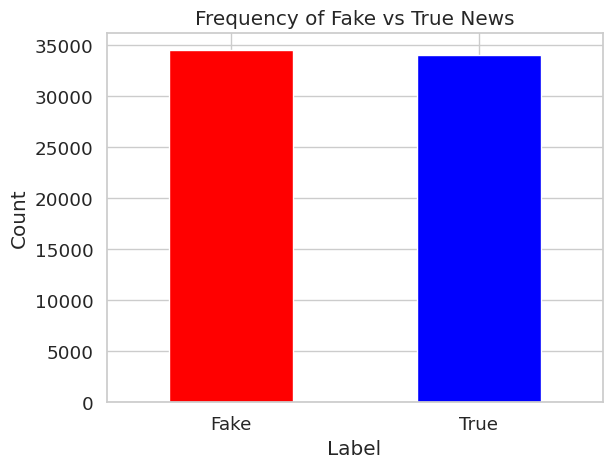

In [78]:
df['label'].value_counts().plot(kind = 'bar', color = ['red', 'blue'])
plt.title("Frequency of Fake vs True News")
plt.xticks(ticks = [0, 1], labels = ['Fake', 'True'], rotation = 0)
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

In [79]:
percent_real = len(df[df['label'] == 1 ])/ len(df)*100
percent_fake = len(df[df['label'] == 0])/ len(df)*100
print(f'There are {len(df)} articles. \n{percent_real:.2f}% are true articles and {percent_fake:.2f}% are fake articles.')

There are 68600 articles. 
50.33% are true articles and 49.67% are fake articles.


#### **2.2 Text Length Analysis**

In [80]:
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

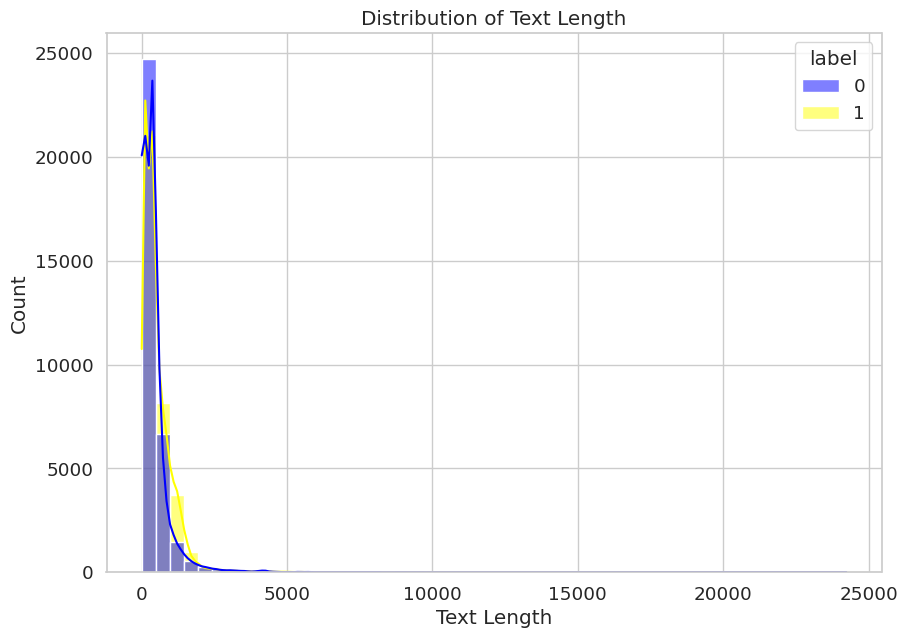

         count        mean         std  min    25%    50%     75%      max
label                                                                     
0      34074.0  426.723425  625.364040  1.0   97.0  331.0  509.00  24234.0
1      34526.0  537.157302  567.222748  1.0  181.0  391.0  724.75  14641.0


In [81]:
plt.figure(figsize = (10, 7))
sns.histplot(data = df, x = 'text_length', hue = 'label', bins = 50, kde = True, palette = ['blue', 'yellow'])
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Count")
plt.show()

print(df.groupby('label')['text_length'].describe())

## **3. Model Building**

#### **3.1 Prepare the data**

Tôi sẽ chia data ra là Train - Validation - Test với tỷ lệ sẽ là 70, 15, 15

In [82]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

df_train, df_test = train_test_split(df, test_size = 0.3, random_state = RANDOM_STATE)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = RANDOM_STATE)

In [83]:
df_train.shape, df_val.shape, df_test.shape

((48020, 3), (10290, 3), (10290, 3))

#### **3.2 Load pre-trained BERT model**

In [84]:
from transformers import BertModel, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

#### **3.3 Create pytorch dataset**

Ở bước này, tôi sẽ xây dựng 1 lớp **Dataset** tùy chỉnh kế thừa từ *torch.utils.data.Dataset* để chuẩn bị dữ liệu văn bản đầu vào phù hợp với mô hình BERT.<br>
Cụ thể:
- Ở mỗi dòng trong dữ liệu sẽ được tokenize bằng **Tokenizer của BERT**, chuyển thành các tensor: *input_ids, attention_mask, và label*
- **Dataset** này đóng vai trò là cầu nối giữa dữ liệu thô và mô hình, giúp chuyển đổi từng văn bản thành định dạng mà mô hình hiểu được

In [85]:
sample_text = df_train['text'].iloc[0]

In [86]:
sample_text

'Five militants and two soldiers were killed on Wednesday in clashes that followed a failed attack on a security checkpoint in Egypt s strife-torn North Sinai province, a military spokesman said. Troops were seeking some of the militants who fled the scene during the clashes, the spokesman said in a statement.   One of the militants, wearing an explosive vest, attempted to raid one of the security checkpoints and due to the vigilance of the security forces the terrorist was killed while the rest of the militants were dealt with,  he said.  Islamic State claimed responsibility for the attack, with its news agency Amaq saying one of its militants had set off a suicide vest at a security checkpoint. An Islamist insurgency in North Sinai has gathered pace since mid-2013 when the military ousted Islamist president Mohamed Mursi after mass protests against his rule and the group leading it pledged allegiance to Islamic State a year later. Hundreds of soldiers and police have been killed sinc

In [87]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length = 128,
    add_special_tokens = True,     # Add [CLS] and [SEP]
    return_token_type_ids = False,
    pad_to_max_length = True,
    return_attention_mask = True,
    return_tensors = 'pt',
    truncation = True
)

encoding.keys()

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'attention_mask'])

In [88]:
encoding['input_ids']

tensor([[  101,  2274, 17671,  1998,  2048,  3548,  2020,  2730,  2006,  9317,
          1999, 17783,  2008,  2628,  1037,  3478,  2886,  2006,  1037,  3036,
         26520,  1999,  5279,  1055, 27865,  1011,  7950,  2167, 20837,  2874,
          1010,  1037,  2510, 14056,  2056,  1012,  3629,  2020,  6224,  2070,
          1997,  1996, 17671,  2040,  6783,  1996,  3496,  2076,  1996, 17783,
          1010,  1996, 14056,  2056,  1999,  1037,  4861,  1012,  2028,  1997,
          1996, 17671,  1010,  4147,  2019, 11355, 17447,  1010,  4692,  2000,
          8118,  2028,  1997,  1996,  3036, 26520,  2015,  1998,  2349,  2000,
          1996,  6819, 20142,  6651,  1997,  1996,  3036,  2749,  1996,  9452,
          2001,  2730,  2096,  1996,  2717,  1997,  1996, 17671,  2020,  9411,
          2007,  1010,  2002,  2056,  1012,  5499,  2110,  3555,  5368,  2005,
          1996,  2886,  1010,  2007,  2049,  2739,  4034, 25933,  4160,  3038,
          2028,  1997,  2049, 17671,  2018,  2275,  

In [89]:
encoding['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

In [90]:
encoding['input_ids'].shape, encoding['attention_mask'].shape

(torch.Size([1, 128]), torch.Size([1, 128]))

**max_length** là mặc định độ dài tối đa của chuỗi <br>
**add_special_tokens** là để tự thêm [CLS] và [SEP] (phân tách câu) <br>
**pad_to_max** là đệm chuỗi ngắn hơn max_length đã set bằng token [PAD] <br>
**return_attention_mask** là để BERT biết phần nào của chuỗi là dữ liệu thực (1) nào là được padding (0)vào <br>
**return_tensors** trả về dạng tensor PyTorch thay vì là list Python <br>
**truncation** là cắt bỏ phần văn bản nếu vượt quá ký tự max_length đã set

In [91]:
from torch.utils.data import Dataset, DataLoader

class FakeNewsDataset(Dataset):
  def __init__(self, text, label, tokenizer, max_length):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.text)

  def __getitem__(self, index):
    text = self.text[index]
    label = self.label[index]

    encoding = self.tokenizer.encode_plus(
        text,
        max_length = self.max_length,
        add_special_tokens = True,     # Add [CLS] and [SEP]
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt',
        truncation = True
    )

    return {
        'text': text,
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'label': torch.tensor(label, dtype = torch.long)
    }

#### **3.4 Create a DataLoader**

Sau khi đã xây dựng một Dataset chuẩn từ dữ liệu, bước tiếp theo là tạo **DataLoader** để hỗ trợ quá trình huấn luyện và đánh giá mô hình hiệu quả hơn.<br> **Mục tiêu chính** của nó là tự động chia tập dữ liệu ra thành các mini-batch, đồng thời hỗ trợ việc shuffle data và load dữ liệu, quản lý dữ liệu theo từng batch trong quá trình huấn luyện.

In [92]:
def create_data_loader(df, tokenizer, max_length, batch_size):
  dataset = FakeNewsDataset(
      text = df['text'].to_numpy(),
      label = df['label'].to_numpy(),
      tokenizer = tokenizer,
      max_length = max_length
  )

  return DataLoader(
      dataset,
      batch_size = batch_size,
      num_workers = 2,
      pin_memory = True,
      shuffle = True
  )

In [93]:
MAX_LEN = 128
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

#### **3.5 Build & Load model**

Bước này tôi sẽ xây dựng một mô hình học sâu dựa trên **BERT pre-trained** để giải quyết bài toán.

In [94]:
class FakeNewsDetection(nn.Module):
    def __init__(self, n_classes, model_name="bert-base-uncased"):
        super(FakeNewsDetection, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)               # BERT backbone
        self.drop = nn.Dropout(p=0.3)                                   # Dropout layer
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)   # Fully-connected layer (classifier)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        pooled_output = outputs.pooler_output    # shape: (batch, hidden_size): Lấy vector của token đầu tiên [CLS], đại diện cho toàn câu
        output = self.drop(pooled_output)
        return self.out(output)

In [95]:
class_names = ['Fake', 'True']
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
model = FakeNewsDetection(len(class_names))
model = model.to(device)

## **4. Hyperparameter set up**

#### **4.1 Set up hyperparameters for training step**

In [97]:
from torch.optim import AdamW
from transformers import get_scheduler

EPOCHS = 5

optimizer = AdamW(model.parameters(), lr= 2e-5, weight_decay=0.01)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_scheduler(
    name = 'linear',
    optimizer = optimizer,
    num_warmup_steps = int(0.1 * total_steps),
    num_training_steps = total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

#### **4.2 Create a training & evaluating workflow**

Training Workflow

In [98]:
from tqdm import tqdm
import numpy as np
import torch
import os
from sklearn.metrics import f1_score

def train_epochs(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    preds_list = []
    labels_list = []

    progress_bar = tqdm(data_loader, desc = "Training", total = len(data_loader), leave = True)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        label = batch['label'].to(device)

        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, label)

        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())
        preds_list.extend(preds.cpu().numpy())
        labels_list.extend(label.cpu().numpy())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'Loss': f'{loss.item():.4f}', 'Acc': f'{(correct_predictions.double() / n_examples).item() * 100:.2f}%'})

    accuracy = correct_predictions.double() / n_examples
    f1 = f1_score(labels_list, preds_list, average='binary')
    return accuracy, np.mean(losses), f1

Evaluating Workflow

In [99]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    preds_list = []
    labels_list = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            label = batch['label'].to(device)

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim = 1)
            loss = loss_fn(outputs, label)

            correct_predictions += torch.sum(preds == label)
            losses.append(loss.item())
            preds_list.extend(preds.cpu().numpy())
            labels_list.extend(label.cpu().numpy())

    accuracy = correct_predictions.double() / n_examples
    f1 = f1_score(labels_list, preds_list, average='binary')
    return accuracy, np.mean(losses), f1 

## **5. Model Training**

In [100]:
%%time
history = {'train_acc': [], 'train_loss': [], 'train_f1': [], 'val_acc': [], 'val_loss': [], 'val_f1': []}
best_f1 = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 20)

    train_acc, train_loss, train_f1 = train_epochs(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f} F1 {train_f1:.4f}')

    val_acc, val_loss, val_f1 = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val loss {val_loss:.4f} accuracy {val_acc:.4f} F1 {val_f1:.4f}')
    print()

    # Lưu lịch sử
    history['train_acc'].append(train_acc.cpu())
    history['train_loss'].append(train_loss)
    history['train_f1'].append(train_f1)
    history['val_acc'].append(val_acc.cpu())
    history['val_loss'].append(val_loss)
    history['val_f1'].append(val_f1)

    # Lưu checkpoint vào /kaggle/working/
    if val_f1 > best_f1:
        best_f1 = val_f1
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_f1': best_f1,
            'history': history
        }
        torch.save(checkpoint, '/kaggle/working/best_model_checkpoint.pt')
        print(f"New best model saved with F1: {best_f1:.4f}")

Epoch 1/5
--------------------


Training: 100%|██████████| 3002/3002 [18:39<00:00,  2.68it/s, Loss=0.0005, Acc=93.24%]

Train loss 0.1688 accuracy 0.9324 F1 0.9322



/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input

Val loss 0.0893 accuracy 0.9809 F1 0.9807

New best model saved with F1: 0.9807
Epoch 2/5
--------------------


Training:   0%|          | 0/3002 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.0468 accuracy 0.9884 F1 0.9885



/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input

Val loss 0.0669 accuracy 0.9841 F1 0.9841

New best model saved with F1: 0.9841
Epoch 3/5
--------------------


Training:   0%|          | 0/3002 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.0166 accuracy 0.9964 F1 0.9964


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.0718 accuracy 0.9871 F1 0.9871

New best model saved with F1: 0.9871
Epoch 4/5
--------------------


Training:   0%|          | 0/3002 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.0075 accuracy 0.9984 F1 0.9984


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.0814 accuracy 0.9870 F1 0.9870

Epoch 5/5
--------------------


Training:   0%|          | 0/3002 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or lea

Train loss 0.0020 accuracy 0.9996 F1 0.9996


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Val loss 0.0965 accuracy 0.9871 F1 0.9871

New best model saved with F1: 0.9871
CPU times: user 1h 39min 54s, sys: 30.8 s, total: 1h 40min 24s
Wall time: 1h 40min 6s


(0.0, 1.0)

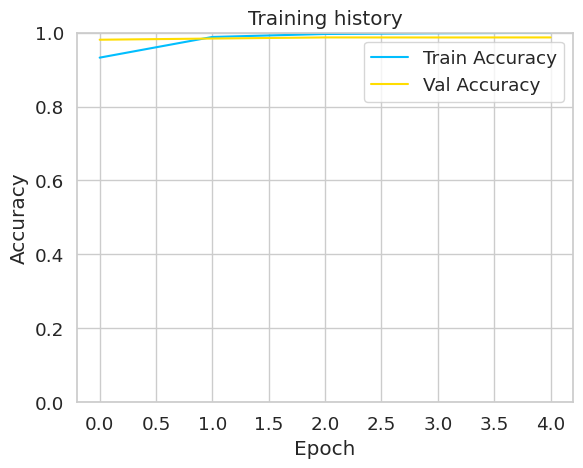

In [101]:
plt.plot(history['train_acc'], label = 'Train Accuracy')
plt.plot(history['val_acc'], label = 'Val Accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

## **6. Performance Evaluation**

In [103]:
test_acc, test_loss, test_f1 = eval_model(
    model,
    test_data_loader,
    loss_fn,
    device,
    len(df_test)
)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}, Test F1: {test_f1:.4f}")

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

Test Accuracy: 0.9882, Test Loss: 0.0877, Test F1: 0.9885


In [ ]:
import torch.nn.functional as F

def get_predictions(model, data_loader):
    model = model.eval()

    # review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            # texts = d["text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)  

            outputs = model(input_ids = input_ids, attention_mask = attention_mask)
            _, preds = torch.max(outputs, dim = 1)

            probs = F.softmax(outputs, dim = 1) 

            # review_texts.extend(texts)
            predictions.extend(preds.cpu().numpy())  
            prediction_probs.extend(probs.cpu().numpy())  
            real_values.extend(labels.cpu().numpy()) 

    predictions = torch.tensor(predictions)
    prediction_probs = torch.tensor(prediction_probs)
    real_values = torch.tensor(real_values)
    return predictions, prediction_probs, real_values

In [109]:
y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2700: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input 

In [110]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Fake       0.99      0.99      0.99      5039
        True       0.99      0.99      0.99      5251

    accuracy                           0.99     10290
   macro avg       0.99      0.99      0.99     10290
weighted avg       0.99      0.99      0.99     10290



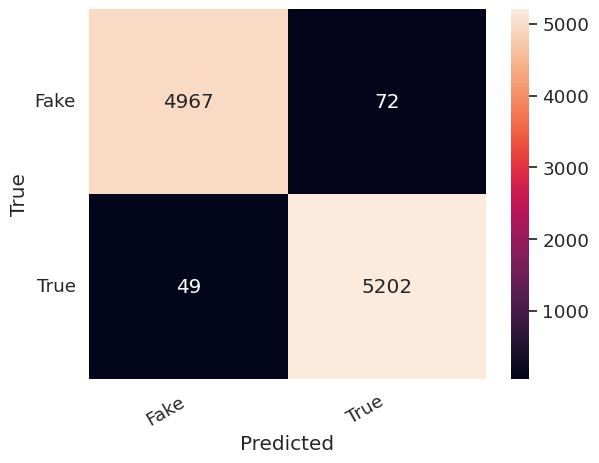

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## **7. Model Inference**

In [114]:
class ModelInference:
    def __init__(self, model, tokenizer, device, max_len=128):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.max_len = max_len

    def predict(self, text):
        self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids = encoding['input_ids'].to(self.device)
        attention_mask = encoding['attention_mask'].to(self.device)

        with torch.no_grad():
            outputs = self.model(
                input_ids = input_ids,
                attention_mask = attention_mask
            )

        prediction = torch.argmax(outputs, dim=1).cpu().numpy()[0]
        return "The news is TRUE!" if prediction == 1 else "The news is FAKE!"

In [115]:
inference = ModelInference(model, tokenizer, device, max_len=MAX_LEN)
sample_text = "A secret government document leaked online reveals that the COVID-19 pandemic was entirely fabricated to allow mass surveillance via 5G towers. Scientists involved in vaccine development are part of a larger plan to control global behavior."
prediction = inference.predict(sample_text)
print(f"\nSample Prediction:")
print(f"Text: {sample_text}")
print(f"Prediction: {prediction}")


Sample Prediction:
Text: A secret government document leaked online reveals that the COVID-19 pandemic was entirely fabricated to allow mass surveillance via 5G towers. Scientists involved in vaccine development are part of a larger plan to control global behavior.
Prediction: The news is FAKE!


In [117]:
inference = ModelInference(model, tokenizer, device, max_len=MAX_LEN)
sample_text = "The CDC announced today that the flu vaccine for the 2024-2025 season is proving to be 68% effective against the most common strains so far this year. Public health experts urge people to get vaccinated, especially children, the elderly, and those with chronic conditions."
prediction = inference.predict(sample_text)
print(f"\nSample Prediction:")
print(f"Text: {sample_text}")
print(f"Prediction: {prediction}")


Sample Prediction:
Text: The CDC announced today that the flu vaccine for the 2024-2025 season is proving to be 68% effective against the most common strains so far this year. Public health experts urge people to get vaccinated, especially children, the elderly, and those with chronic conditions.
Prediction: The news is FAKE!
